In [130]:
import numpy as np
from numpy import linalg
import plotly.express as px
from plotly.offline import iplot
import polars as pl
from typing import Dict
from PIL import Image
from functools import reduce
from operator import mul
from skimage.color import rgb2yiq, yiq2rgb
from pathlib import Path
from IPython.display import display
from commom import (
    load_images,
    get_img_matrixes,
    get_img_dfs,
    get_metrics,
    apply_filter,
    get_histograma,
    norm_hist,
)

# Trabalho Contraste

Esse trabalho foi desenvolvido durante no Semestre 01/2023, para a disciplina de Processamento de Imagens (PIM).

Universidade Estadual de Santa Catarina.

Autores:
- Andrei
- Otávio Almeida

Orientador:
- Gilmário B. Santos

## Etapa 1

In [131]:
IMG_FOLDER = Path("../data")

image_paths = [
    IMG_FOLDER / "figuraEscura.jpg",
    IMG_FOLDER / "figuraClara.jpg",
    IMG_FOLDER / "lena_B.png",
]


images = load_images(image_paths=image_paths)

#### Imagens Originais

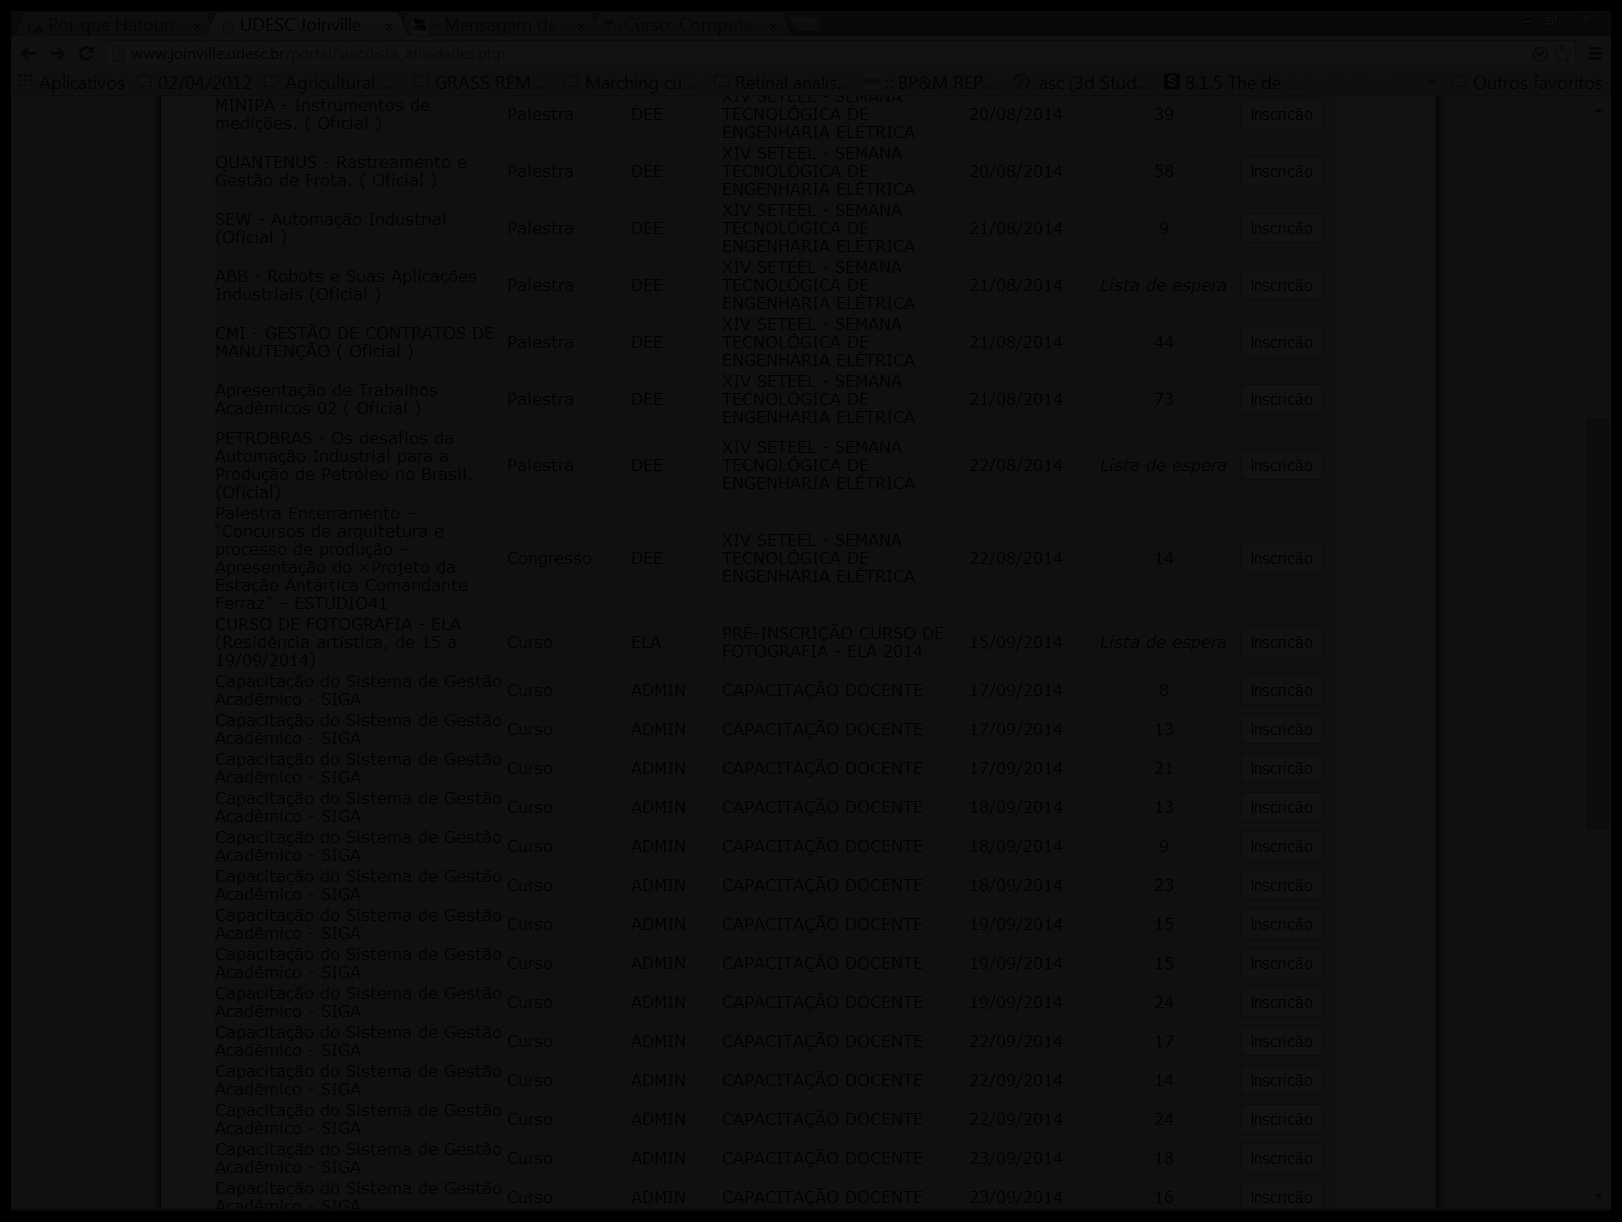

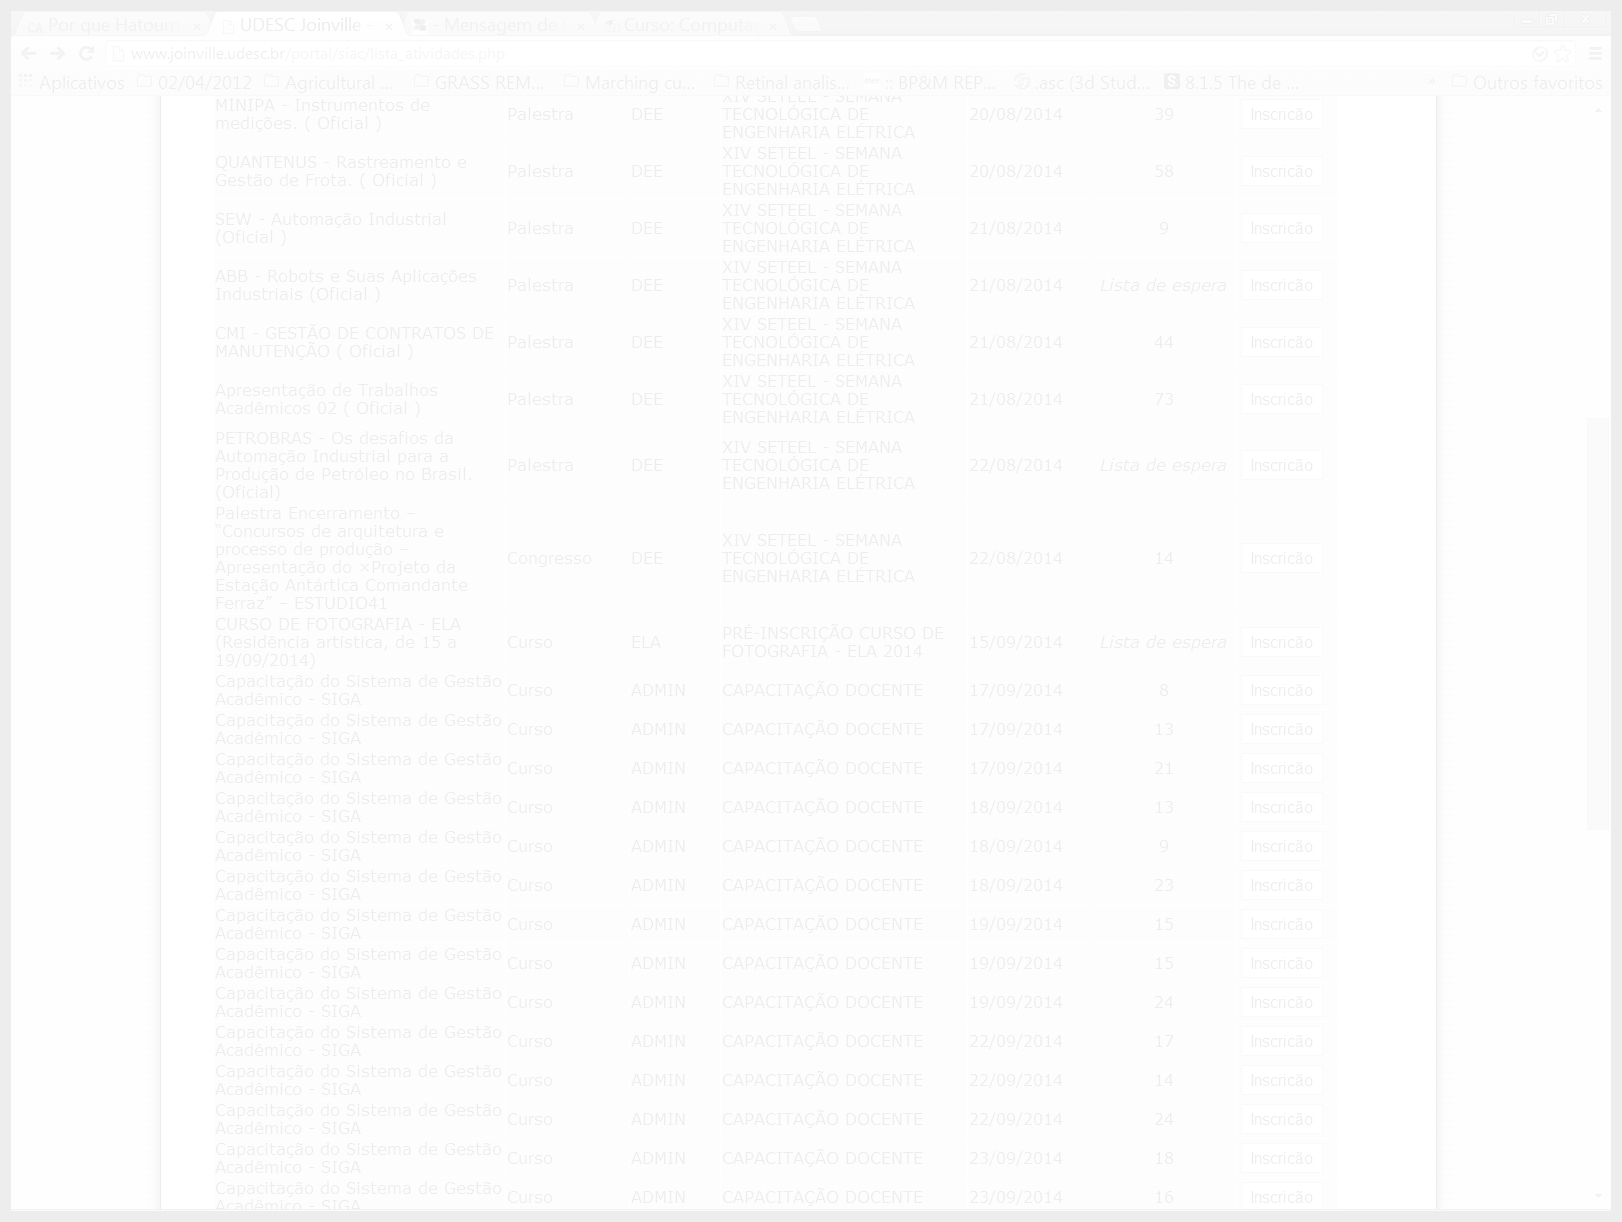

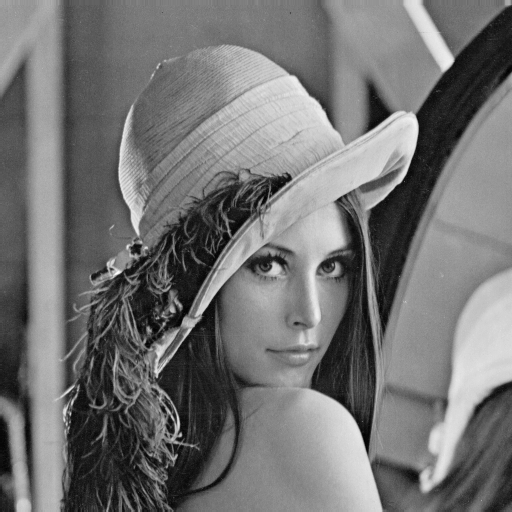

In [132]:
for index, image in images.items():
    display(image)

In [133]:
images_matrix = get_img_matrixes(images)
images_dfs = get_img_dfs(images_matrix)

#### Métricas

In [134]:
get_metrics(images_dfs, images).to_pandas()

Nomes      Médias    Desvios  Entropias
0  figuraEscura.jpg   15.063616   4.197902   2.218035
1   figuraClara.jpg  252.063785   4.204018   2.220315
2        lena_B.png  115.029488  55.220277   7.445526

#### Métricas

In [135]:
for name, df in images_dfs.items():
    grouped_df = df.groupby("Pixels").agg(
        pl.col("Pixels").count().alias("Qtd Pixels").cast(pl.UInt64)
    )
    non_existent_gray_values = np.array(
        [grey for grey in range(256) if grey not in grouped_df["Pixels"].unique()],
        dtype=np.uint8,
    )
    missing_df = pl.DataFrame(
        {
            "Pixels": non_existent_gray_values,
            "Qtd Pixels": np.zeros(non_existent_gray_values.shape),
        },
        schema={"Pixels": pl.UInt8, "Qtd Pixels": pl.UInt64},
    )
    histogram_df = pl.concat([grouped_df, missing_df], how="vertical")
    fig = px.bar(
        title=f"Histograma {name}",
        data_frame=histogram_df.to_pandas(),
        x="Pixels",
        y="Qtd Pixels",
    )
    iplot(fig)

## Etapa 2

In [136]:
# Load Images
image_paths = [
    IMG_FOLDER / "figuraEscura.jpg",
    IMG_FOLDER / "figuraClara.jpg",
    IMG_FOLDER / "xadrez_lowCont.png",
    IMG_FOLDER / "marilyn.jpg",
]

images = load_images(image_paths)



#### Imagens Originais

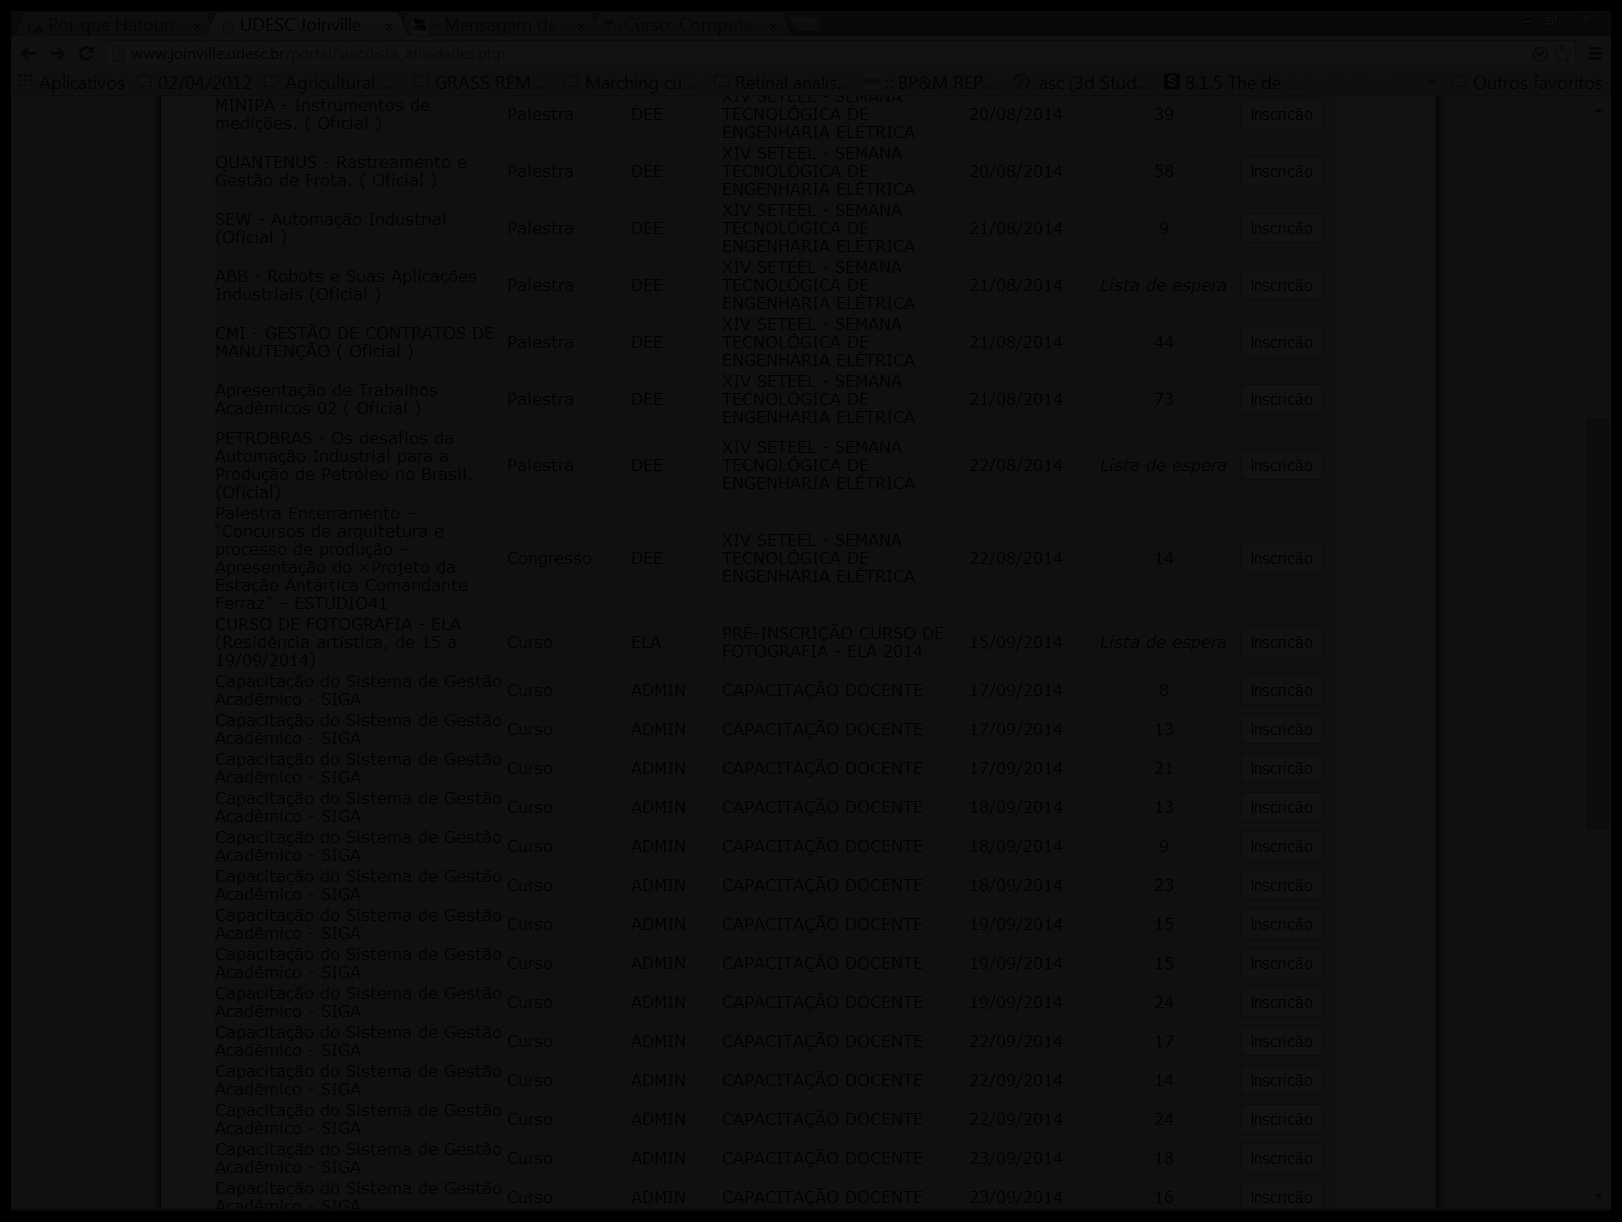

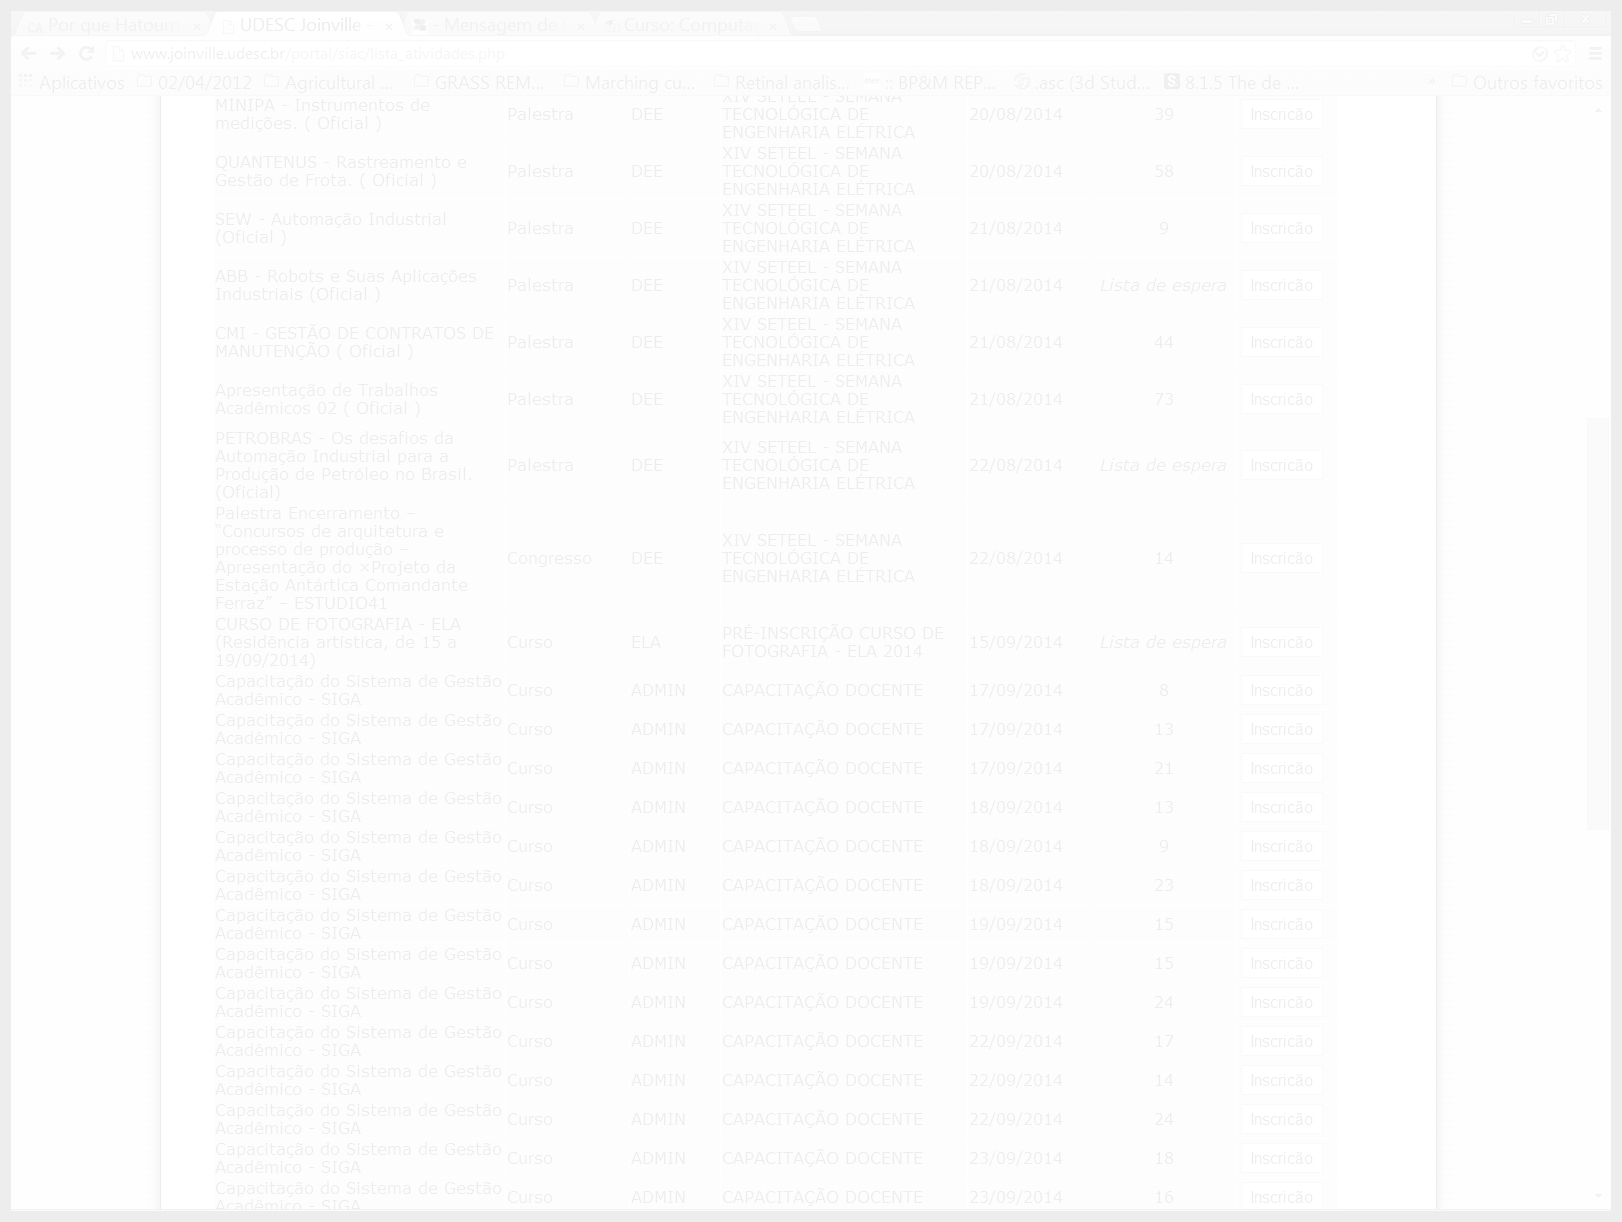

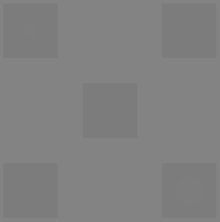

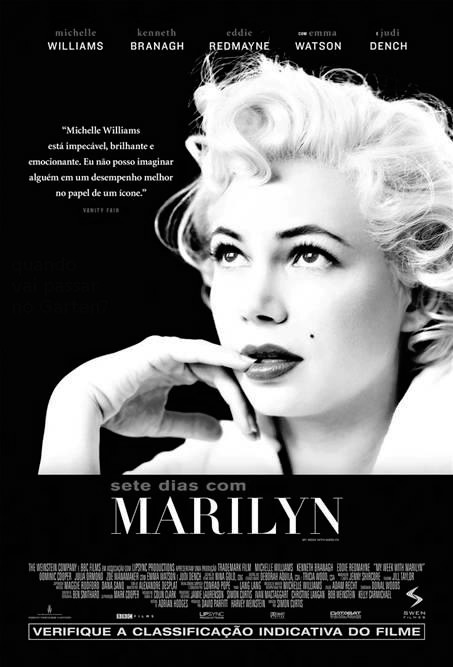

In [137]:
for index, image in images.items():
    display(image)


In [138]:
images_matrix = get_img_matrixes(images)
images_dfs = get_img_dfs(images_matrix)

#### Métricas

In [139]:
get_metrics(images_dfs, images).to_pandas()

Nomes      Médias     Desvios  Entropias
0    figuraEscura.jpg   15.063616    4.197902   2.218035
1     figuraClara.jpg  252.063785    4.204018   2.220315
2  xadrez_lowCont.png  128.889169    3.159936   1.175479
3         marilyn.jpg   88.540068  103.111823   5.590523

In [140]:
histogramas: Dict[str, pl.DataFrame] = dict()

# Histogram
for name, df in images_dfs.items():
    histogram_df = get_histograma(df)
    histogramas[name] = histogram_df

In [141]:
conversion_funcs: Dict[str, np.ndarray] = dict()
probs_dfs: Dict[str, pl.DataFrame] = dict()
for name, histogram_df in histogramas.items():
    probs_df = norm_hist(
        histogram_df.sort("Pixels", descending=False)["Qtd Pixels"].to_numpy()
    )
    probs_dfs[name] = probs_df

    probs_rounded_df = probs_df.filter(pl.col("Type") == "Rounded Sum")
    probs_rounded = probs_rounded_df.to_pandas()

    conversion_funcs[name] = probs_rounded["Probability"].to_numpy()

In [142]:
norm_images: Dict[str, Image.Image] = dict()
for name, image in images.items():
    pixels = np.array(image)
    pixels_norm = apply_filter(name, pixels, conversion_funcs)
    # pixels_norm = pixels_norm.reshape(images_matrix[name].shape)
    img_norm = Image.fromarray(pixels_norm)
    norm_images[name] = img_norm.convert("L")

In [143]:
norm_images_matrix = get_img_matrixes(norm_images)
norm_images_dfs = get_img_dfs(norm_images_matrix)

#### Histogramas

In [144]:
histogramas_norm: Dict[str, pl.DataFrame] = dict()

for name, df in norm_images_dfs.items():
    histogram_df_norm = get_histograma(df)
    histogram_df = histogramas[name]
    histogramas_norm[name] = histogram_df_norm

    iplot(
        px.bar(
            title=f"Histograma {name}",
            data_frame=histogram_df.to_pandas(),
            x="Pixels",
            y="Qtd Pixels",
        ),
    )
    iplot(
        px.bar(
            title=f"Histograma {name} Normalizado",
            data_frame=histogram_df_norm.to_pandas(),
            x="Pixels",
            y="Qtd Pixels",
        ),
    )
    iplot(
        px.line(
            title=f"Probabilidade Somada {name}",
            data_frame=probs_dfs[name].to_pandas(),
            x="IndexProb",
            y="Probability",
            color="Type",
        )
    )

#### Imagens Normalizadas

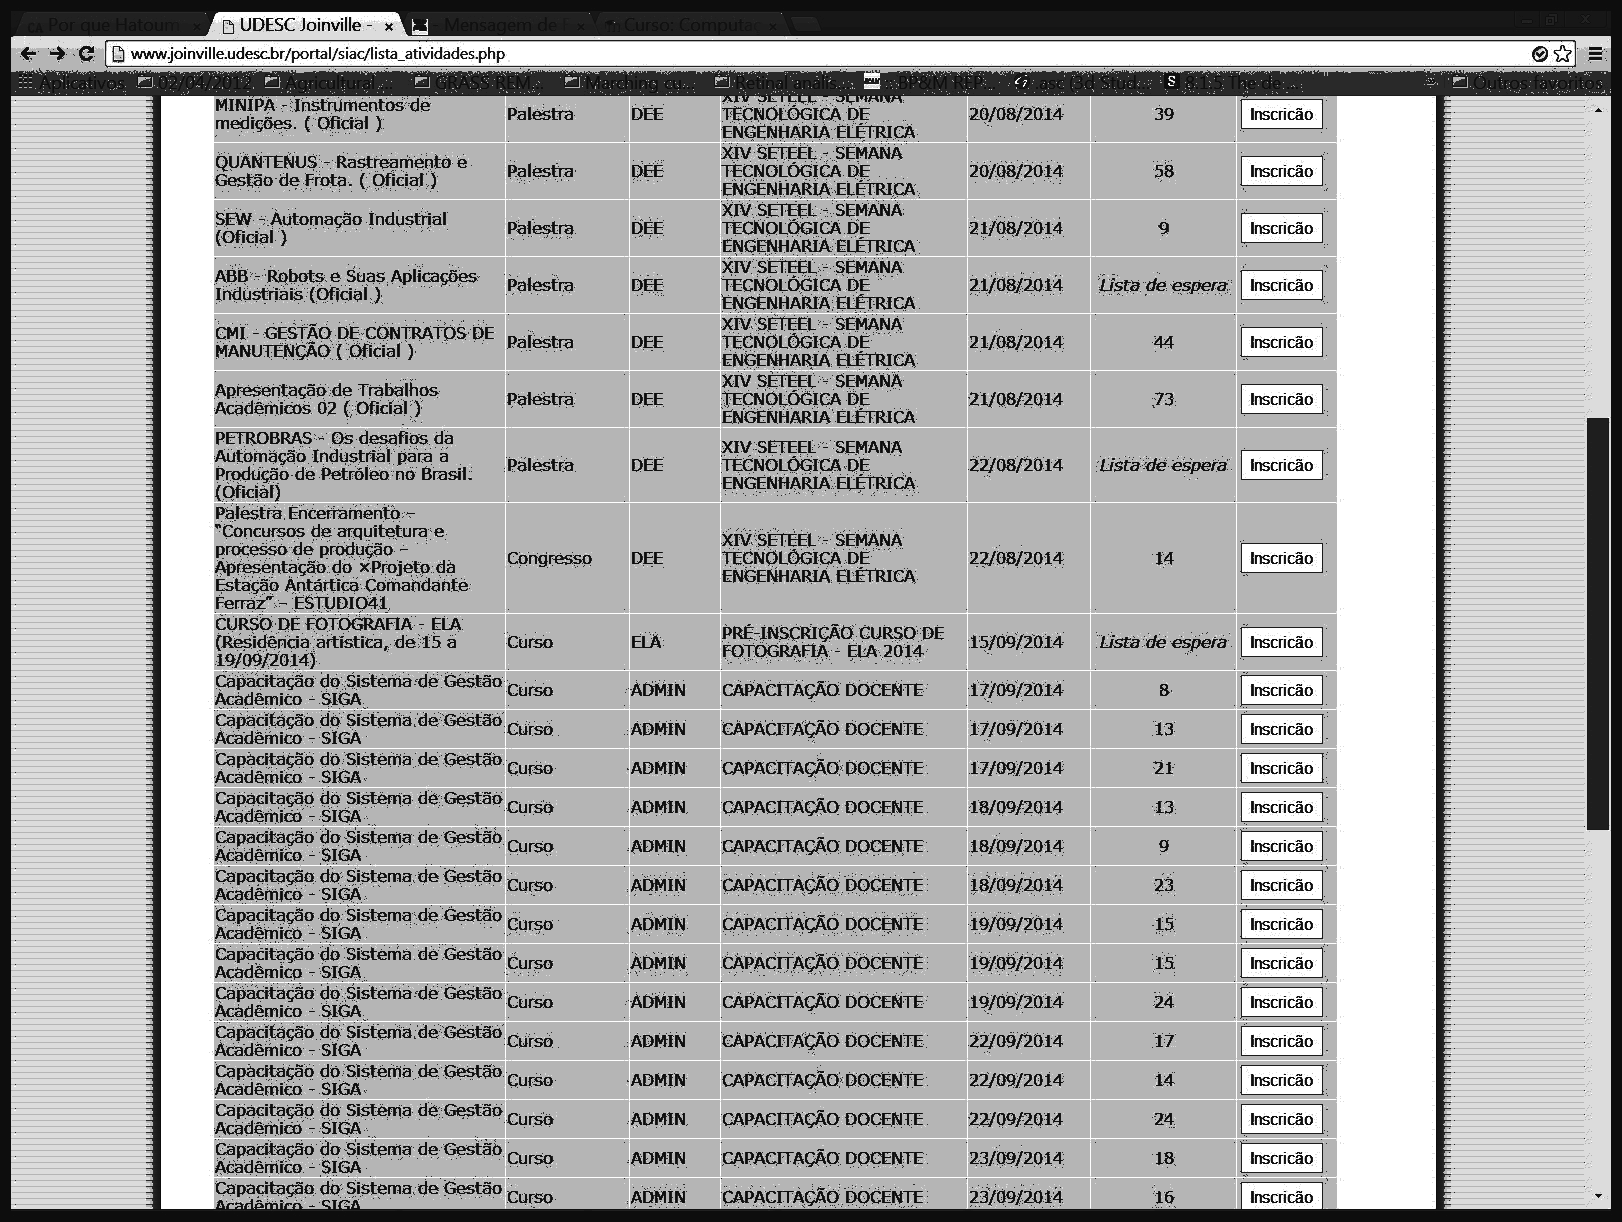

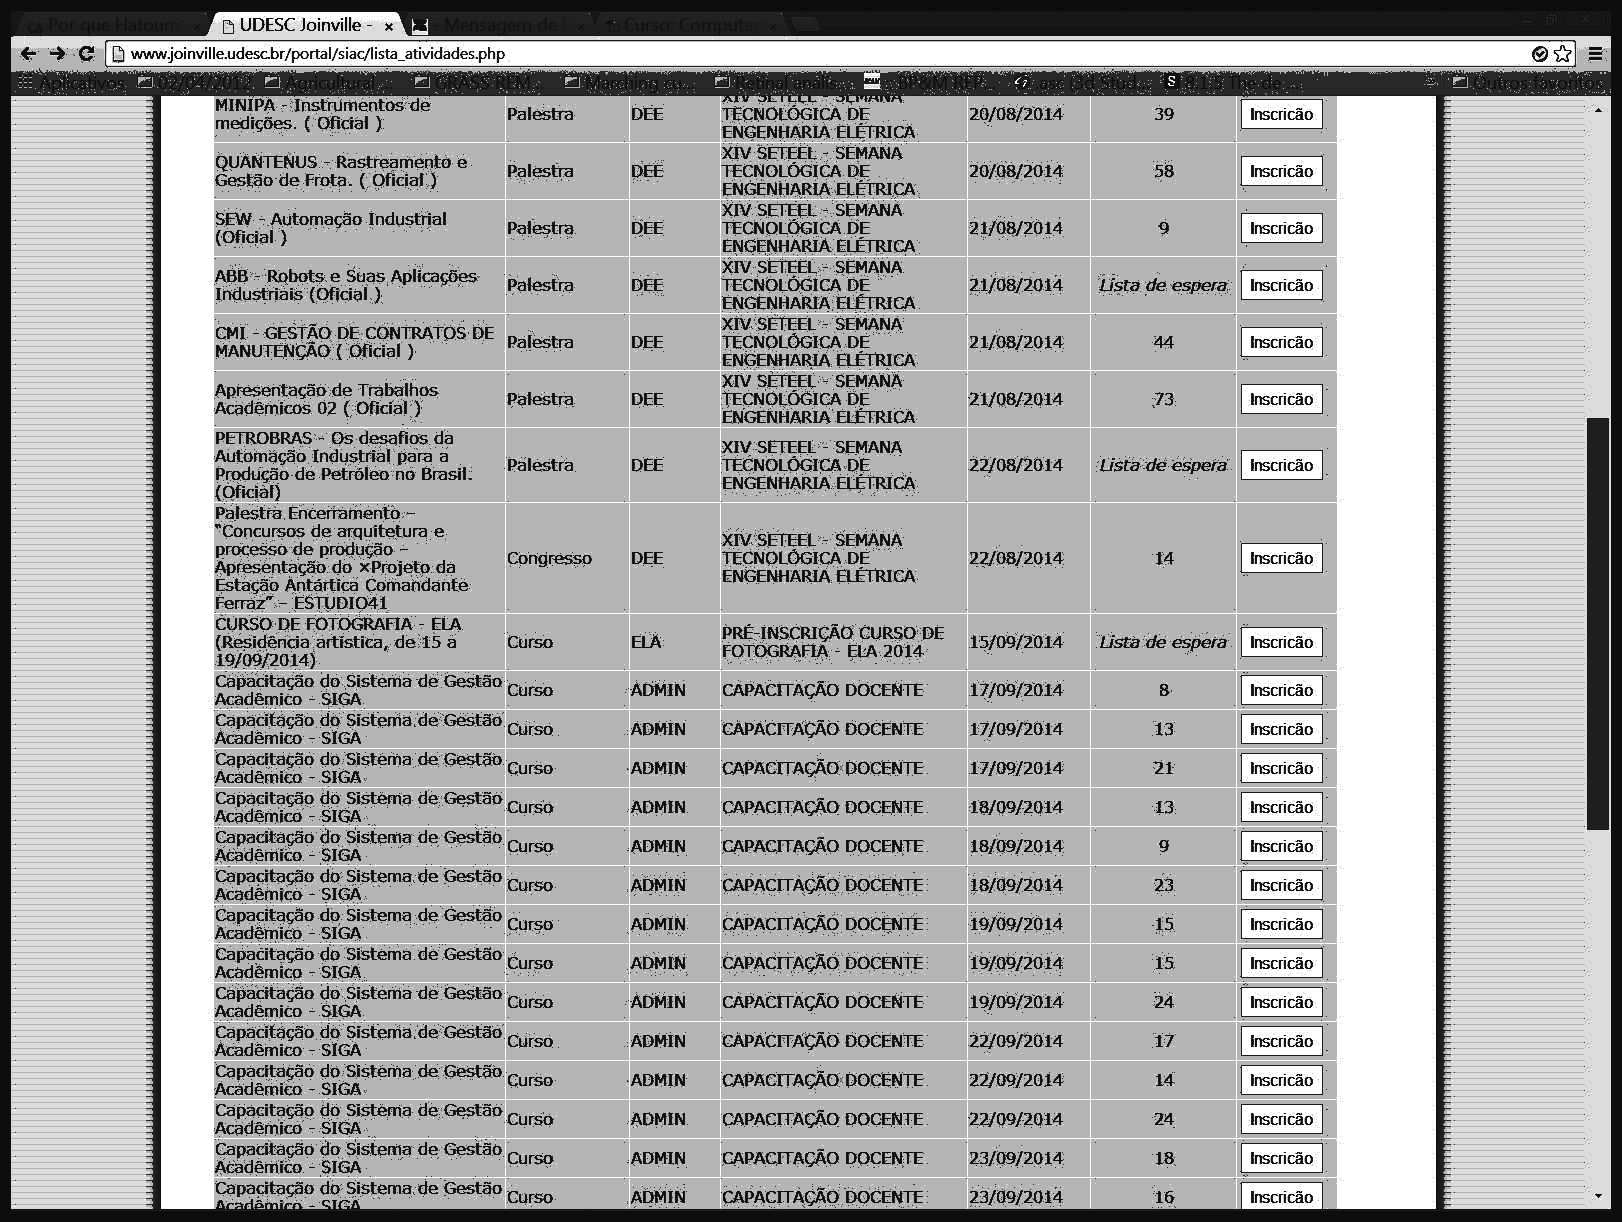

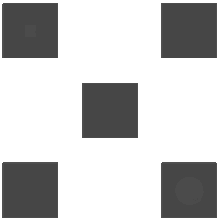

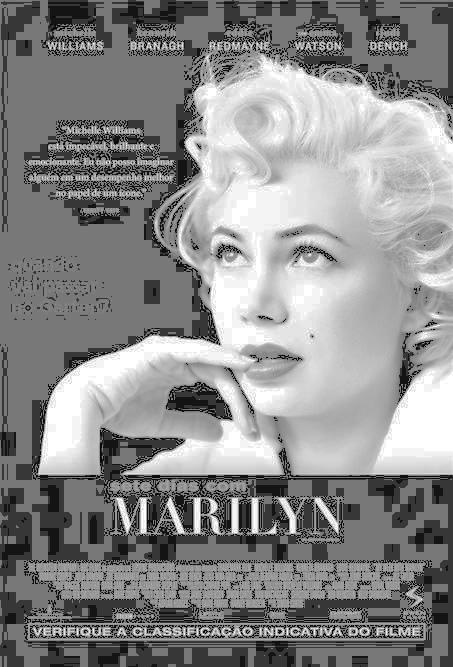

In [145]:
for index, image in norm_images.items():
        display(image)

## Etapa 3

In [146]:
image_paths = [
    IMG_FOLDER / "outono_LC.png",
    IMG_FOLDER / "predios.jpeg",
]

images = load_images(image_paths, "RGB")

#### Imagens Originais

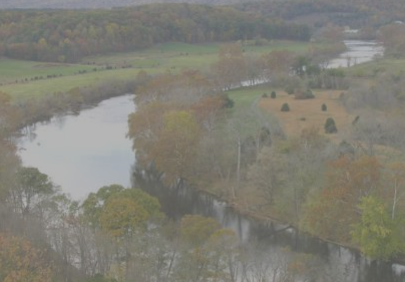

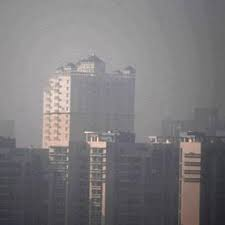

In [147]:
for index, image in images.items():
    display(image)

#### Imagens Normalizadas sobre canais RGB

In [148]:
image_matrixes = get_img_matrixes(images)

In [149]:
def get_img_dfs_rgb(images_matrix: Dict[str, np.ndarray]):
    return {
        name: pl.DataFrame(
            data={
                "PixelsR": matrix[:, :, 0].reshape(reduce(mul, matrix.shape[:-1])),
                "PixelsG": matrix[:, :, 1].reshape(reduce(mul, matrix.shape[:-1])),
                "PixelsB": matrix[:, :, 2].reshape(reduce(mul, matrix.shape[:-1])),
            },
            schema={"PixelsR": pl.UInt8, "PixelsG": pl.UInt8, "PixelsB": pl.UInt8},
        )
        for name, matrix in images_matrix.items()
    }

In [150]:
images_dfs = get_img_dfs_rgb(image_matrixes)
histogramas_rgb: Dict[str, Dict[str, pl.DataFrame]] = dict()

for name, df in images_dfs.items():
    histogram_df_red = get_histograma(df, "PixelsR")
    histogram_df_blue = get_histograma(df, "PixelsB")
    histogram_df_green = get_histograma(df, "PixelsG")
    histogramas_rgb[f"{name}"] = {
        "red": histogram_df_red,
        "green": histogram_df_green,
        "blue": histogram_df_blue,
    }

In [151]:
conversion_rgb_funcs: Dict[str, np.ndarray] = dict()
probs_rgb_dfs: Dict[str, Dict[str, pl.DataFrame]] = dict()
for name, histogram_df in histogramas_rgb.items():
    probs_df_red = norm_hist(
        histogram_df["red"].sort("PixelsR", descending=False)["Qtd Pixels"].to_numpy()
    )
    probs_df_green = norm_hist(
        histogram_df["green"].sort("PixelsG", descending=False)["Qtd Pixels"].to_numpy()
    )
    probs_df_blue = norm_hist(
        histogram_df["blue"].sort("PixelsB", descending=False)["Qtd Pixels"].to_numpy()
    )

    probs_rgb_dfs[name] = {
        "red": probs_df_red,
        "green": probs_df_green,
        "blue": probs_df_blue,
    }

    probs_rounded_red_df = probs_df_red.filter(pl.col("Type") == "Rounded Sum")
    probs_rounded_green_df = probs_df_green.filter(pl.col("Type") == "Rounded Sum")
    probs_rounded_blue_df = probs_df_blue.filter(pl.col("Type") == "Rounded Sum")

    conversion_rgb_funcs[f"{name} red"] = probs_rounded_red_df["Probability"].to_numpy()
    conversion_rgb_funcs[f"{name} green"] = probs_rounded_green_df[
        "Probability"
    ].to_numpy()
    conversion_rgb_funcs[f"{name} blue"] = probs_rounded_blue_df[
        "Probability"
    ].to_numpy()

In [152]:
norm_rgb_images: Dict[str, Image.Image] = dict()
for name, image in images.items():
    pixels = np.array(image)
    pixels_norm_red = apply_filter(f"{name} red", pixels[:, :, 0], conversion_rgb_funcs)
    pixels_norm_green = apply_filter(
        f"{name} green", pixels[:, :, 1], conversion_rgb_funcs
    )
    pixels_norm_blue = apply_filter(
        f"{name} blue", pixels[:, :, 2], conversion_rgb_funcs
    )
    image_arr = np.zeros((*pixels_norm_blue.shape, 3), dtype=np.uint8)
    # pixels_norm = pixels_norm.reshape(images_matrix[name].shape)
    image_arr[:, :, 0] = pixels_norm_red
    image_arr[:, :, 1] = pixels_norm_green
    image_arr[:, :, 2] = pixels_norm_blue

    img_norm = Image.fromarray(image_arr)
    norm_rgb_images[name] = img_norm

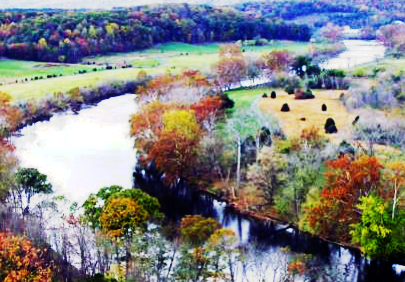

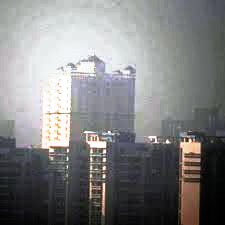

In [153]:
for index, image in norm_rgb_images.items():
    display(image.convert("RGB"))

#### Imagens Normalizadas sobre canal Y (YIQ)

In [154]:
def get_img_dfs_yiq(images_matrix: Dict[str, np.ndarray]):
    return {
        name: pl.DataFrame(
            data={
                "PixelsY": matrix[:, :, 0].reshape(reduce(mul, matrix.shape[:-1])),
                "PixelsI": matrix[:, :, 1].reshape(reduce(mul, matrix.shape[:-1])),
                "PixelsQ": matrix[:, :, 2].reshape(reduce(mul, matrix.shape[:-1])),
            },
            schema={"PixelsY": pl.UInt8, "PixelsI": pl.UInt8, "PixelsQ": pl.UInt8},
        )
        for name, matrix in [
            (
                name,
                (
                    255
                    * (
                        rgb2yiq(np.array(image) / 255)
                        - np.min(rgb2yiq(np.array(image) / 255))
                        / np.max(
                            rgb2yiq(np.array(image) / 255)
                            - np.min(rgb2yiq(np.array(image) / 255))
                        )
                    )
                ).astype(np.uint8),
            )
            for name, image in images_matrix.items()
        ]
    }

In [155]:
images_dfs = get_img_dfs_yiq(image_matrixes)

In [156]:
histogramas_yiq: Dict[str, pl.DataFrame] = dict()
for name, df in images_dfs.items():
    histogram_df = get_histograma(df, "PixelsY")
    histogramas_yiq[name] = histogram_df

In [157]:
conversion_yiq_funcs: Dict[str, np.ndarray] = dict()
probs_yiq_dfs: Dict[str, pl.DataFrame] = dict()
for name, histogram_df in histogramas_yiq.items():
    probs_df_y = norm_hist(
        histogram_df.sort("PixelsY", descending=False)["Qtd Pixels"].to_numpy()
    )

    probs_yiq_dfs[name] = probs_df_y

    probs_rounded_y_df = probs_df_y.filter(pl.col("Type") == "Rounded Sum")

    conversion_yiq_funcs[name] = probs_rounded_y_df["Probability"].to_numpy()

In [158]:
histogramas_norm_yiq: Dict[str, pl.DataFrame] = dict()
norm_yiq_images: Dict[str, Image.Image] = dict()
for name, df in images_dfs.items():
    image = image_matrixes[name]
    pixels = df["PixelsY"].to_numpy().reshape(image.shape[:-1])

    pixels_norm_y = apply_filter(name, pixels, conversion_yiq_funcs)

    image_arr = image.copy()
    # pixels_norm = pixels_norm.reshape(images_matrix[name].shape)
    image_arr[:, :, 0] = pixels_norm_y
    image_arr[:, :, 1] = df["PixelsI"].to_numpy().reshape(image.shape[:-1])
    image_arr[:, :, 2] = df["PixelsQ"].to_numpy().reshape(image.shape[:-1])
    image_arr = yiq2rgb(image_arr / 255)

    image_arr_m = image_arr[:, :, 0] - np.min(image_arr[:, :, 0])
    image_arr_n = np.rint(255 * (image_arr_m / np.max(image_arr_m)))
    image_arr[:, :, 0] = image_arr_n
    image_arr_m = image_arr[:, :, 1] - np.min(image_arr[:, :, 1])
    image_arr_n = np.rint(255 * (image_arr_m / np.max(image_arr_m)))
    image_arr[:, :, 1] = image_arr_n
    image_arr_m = image_arr[:, :, 2] - np.min(image_arr[:, :, 2])
    image_arr_n = np.rint(255 * (image_arr_m / np.max(image_arr_m)))
    image_arr[:, :, 2] = image_arr_n

    # image_arr_m = image_arr - np.min(image_arr)
    # image_arr_n = np.rint(255 * (image_arr_m / np.max(image_arr_m)))
    # image_arr = image_arr_n

    img_norm = Image.fromarray(image_arr.astype(np.uint8), mode="RGB")

    histogram_df = get_histograma(
        pl.DataFrame(
            data={
                "PixelsY": pixels_norm_y.reshape(reduce(mul, image_arr.shape[:-1])),
            },
            schema={"PixelsY": pl.UInt8},
        ),
        "PixelsY",
    )

    histogramas_norm_yiq[name] = histogram_df
    norm_yiq_images[name] = img_norm

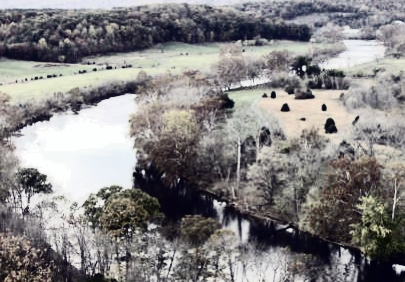

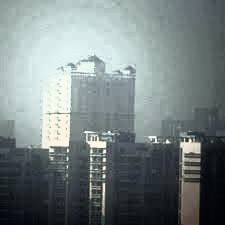

In [159]:
for index, image in norm_yiq_images.items():
    display(image)

#### Histogramas Y

In [160]:
for name, df in histogramas_yiq.items():
    histogram_norm_yiq = histogramas_norm_yiq[name]
    iplot(
        px.bar(
            title=f"Histograma {name}",
            data_frame=df.to_pandas(),
            x="PixelsY",
            y="Qtd Pixels",
        ),
    )
    iplot(
        px.bar(
            title=f"Histograma {name} Normalizado",
            data_frame=histogram_norm_yiq.to_pandas(),
            x="PixelsY",
            y="Qtd Pixels",
        ),
    )
    iplot(
        px.line(
            data_frame=probs_yiq_dfs[name].to_pandas(),
            x="IndexProb",
            y="Probability",
            color="Type",
        )
    )

#### Implementação Própria de Conversão YIQ

In [161]:
def convert_rgb_to_yiq(matriz: np.ndarray) -> np.ndarray:
    yiq_from_rgb = np.array(
        [
            [0.299, 0.587, 0.114],
            [0.59590059, -0.27455667, -0.32134392],
            [0.21153661, -0.52273617, 0.31119955],
        ]
    )
    image_arr = (matriz @ yiq_from_rgb.T.copy()).astype(np.float64)
    # image_arr_m = image_arr[:, :, 0] - np.min(image_arr[:, :, 0])
    # image_arr_n = np.rint(255 * (image_arr_m / np.max(image_arr_m)))
    # image_arr[:, :, 0] = image_arr_n
    # image_arr_m = image_arr[:, :, 1] - np.min(image_arr[:, :, 1])
    # image_arr_n = np.rint(255 * (image_arr_m / np.max(image_arr_m)))
    # image_arr[:, :, 1] = image_arr_n
    # image_arr_m = image_arr[:, :, 2] - np.min(image_arr[:, :, 2])
    # image_arr_n = np.rint(255 * (image_arr_m / np.max(image_arr_m)))
    # image_arr[:, :, 2] = image_arr_n
    image_arr_n = image_arr - np.min(image_arr)
    image_arr = image_arr_n / np.max(image_arr_n)
    return (255 * image_arr).astype(np.uint8)

In [162]:
def convert_yiq_to_rgb(matriz: np.ndarray) -> np.ndarray:
    yiq_from_rgb = np.array(
        [
            [0.299, 0.587, 0.114],
            [0.59590059, -0.27455667, -0.32134392],
            [0.21153661, -0.52273617, 0.31119955],
        ]
    )
    image_arr = (matriz @ linalg.inv(yiq_from_rgb).T.copy()).astype(np.float64)
    
    # image_arr_n = image_arr - np.min(image_arr)
    # image_arr = image_arr_n / np.max(image_arr_n)
    
    image_arr_m = image_arr[:, :, 0] - np.min(image_arr[:, :, 0])
    image_arr_n = np.rint(255 * (image_arr_m / np.max(image_arr_m)))
    image_arr[:, :, 0] = image_arr_n
    image_arr_m = image_arr[:, :, 1] - np.min(image_arr[:, :, 1])
    image_arr_n = np.rint(255 * (image_arr_m / np.max(image_arr_m)))
    image_arr[:, :, 1] = image_arr_n
    image_arr_m = image_arr[:, :, 2] - np.min(image_arr[:, :, 2])
    image_arr_n = np.rint(255 * (image_arr_m / np.max(image_arr_m)))
    image_arr[:, :, 2] = image_arr_n

    return (image_arr).astype(np.uint8)

In [163]:
def get_img_dfs_own_yiq(images_matrix: Dict[str, np.ndarray]):
    return {
        name: pl.DataFrame(
            data={
                "PixelsY": matrix[:, :, 0].reshape(reduce(mul, matrix.shape[:-1])),
                "PixelsI": matrix[:, :, 1].reshape(reduce(mul, matrix.shape[:-1])),
                "PixelsQ": matrix[:, :, 2].reshape(reduce(mul, matrix.shape[:-1])),
            },
            schema={"PixelsY": pl.UInt8, "PixelsI": pl.UInt8, "PixelsQ": pl.UInt8},
        )
        for name, matrix in [
            (
                name,
                convert_rgb_to_yiq(image),
            )
            for name, image in images_matrix.items()
        ]
    }

In [164]:
images_dfs = get_img_dfs_own_yiq(images_matrix=image_matrixes)

In [165]:
histogramas_yiq: Dict[str, pl.DataFrame] = dict()
for name, df in images_dfs.items():
    histogram_df = get_histograma(df, "PixelsY")
    histogramas_yiq[name] = histogram_df

In [166]:
conversion_yiq_funcs: Dict[str, np.ndarray] = dict()
probs_yiq_dfs: Dict[str, pl.DataFrame] = dict()
for name, histogram_df in histogramas_yiq.items():
    probs_df_y = norm_hist(
        histogram_df.sort("PixelsY", descending=False)["Qtd Pixels"].to_numpy()
    )

    probs_yiq_dfs[name] = probs_df_y

    probs_rounded_y_df = probs_df_y.filter(pl.col("Type") == "Rounded Sum")

    conversion_yiq_funcs[name] = probs_rounded_y_df["Probability"].to_numpy()

In [167]:
histogramas_norm_yiq: Dict[str, pl.DataFrame] = dict()
norm_yiq_images: Dict[str, Image.Image] = dict()
for name, df in images_dfs.items():
    image = image_matrixes[name]
    pixels = df["PixelsY"].to_numpy().reshape(image.shape[:-1])

    pixels_norm_y = apply_filter(name, pixels, conversion_yiq_funcs)

    image_arr = image.copy()
    # pixels_norm = pixels_norm.reshape(images_matrix[name].shape)
    image_arr[:, :, 0] = pixels_norm_y
    image_arr[:, :, 1] = df["PixelsI"].to_numpy().reshape(image.shape[:-1])
    image_arr[:, :, 2] = df["PixelsQ"].to_numpy().reshape(image.shape[:-1])
    image_arr = convert_yiq_to_rgb(image_arr)

    # image_arr_m = image_arr[:, :, 0] - np.min(image_arr[:, :, 0])
    # image_arr_n = np.rint(255 * (image_arr_m / np.max(image_arr_m)))
    # image_arr[:, :, 0] = image_arr_n
    # image_arr_m = image_arr[:, :, 1] - np.min(image_arr[:, :, 1])
    # image_arr_n = np.rint(255 * (image_arr_m / np.max(image_arr_m)))
    # image_arr[:, :, 1] = image_arr_n
    # image_arr_m = image_arr[:, :, 2] - np.min(image_arr[:, :, 2])
    # image_arr_n = np.rint(255 * (image_arr_m / np.max(image_arr_m)))
    # image_arr[:, :, 2] = image_arr_n

    # image_arr_m = image_arr - np.min(image_arr)
    # image_arr_n = np.rint(255 * (image_arr_m / np.max(image_arr_m)))
    # image_arr = image_arr_n

    img_norm = Image.fromarray(image_arr.astype(np.uint8), mode="RGB")

    histogram_df = get_histograma(
        pl.DataFrame(
            data={
                "PixelsY": pixels_norm_y.reshape(reduce(mul, image_arr.shape[:-1])),
            },
            schema={"PixelsY": pl.UInt8},
        ),
        "PixelsY",
    )

    histogramas_norm_yiq[name] = histogram_df
    norm_yiq_images[name] = img_norm

#### Imagens Normalizadas sobre canal Y (YIQ)

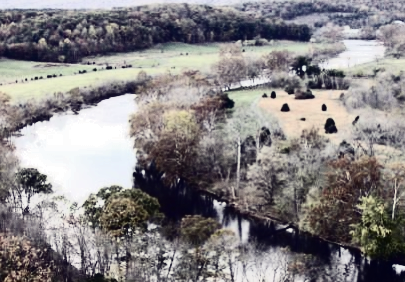

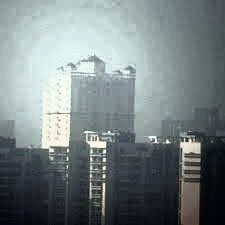

In [168]:
for index, image in norm_yiq_images.items():
    display(image)

#### Histogramas Y

In [169]:
for name, df in histogramas_yiq.items():
    histogram_norm_yiq = histogramas_norm_yiq[name]
    iplot(
            px.bar(
                title=f"Histograma {name}",
                data_frame=df.to_pandas(),
                x="PixelsY",
                y="Qtd Pixels",
            ),
        )
    iplot(
            px.bar(
                title=f"Histograma {name} Normalizado",
                data_frame=histogram_norm_yiq.to_pandas(),
                x="PixelsY",
                y="Qtd Pixels",
            ),
        )
    iplot(
        px.line(
            data_frame=probs_yiq_dfs[name].to_pandas(),
            x="IndexProb",
            y="Probability",
            color="Type",
        )
    )
